### Import Libraries

In [45]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

### Import Dataset

In [3]:
diabetes_df = pd.read_csv("ILPD.csv")
diabetes_df[:3]

age  gender  tot_bilirubin  direct_bilirubin  tot_proteins  albumin  \
0   65  Female            0.7               0.1           187       16   
1   62    Male           10.9               5.5           699       64   
2   62    Male            7.3               4.1           490       60   

   ag_ratio  sgpt  sgot  alkphos  is_patient  
0        18   6.8   3.3     0.90           1  
1       100   7.5   3.2     0.74           1  
2        68   7.0   3.3     0.89           1

In [4]:
del diabetes_df["gender"]

In [5]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               583 non-null    int64  
 1   tot_bilirubin     583 non-null    float64
 2   direct_bilirubin  583 non-null    float64
 3   tot_proteins      583 non-null    int64  
 4   albumin           583 non-null    int64  
 5   ag_ratio          583 non-null    int64  
 6   sgpt              583 non-null    float64
 7   sgot              583 non-null    float64
 8   alkphos           579 non-null    float64
 9   is_patient        583 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 45.7 KB


In [6]:
# Fill Null Values with Mean
diabetes_df["alkphos"] = diabetes_df["alkphos"].fillna(diabetes_df["alkphos"].mean())

In [7]:
# Features
X = diabetes_df[diabetes_df.columns.drop("is_patient")]

# Target
y = diabetes_df["is_patient"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25)

In [9]:
# Fit the scaler on the training features and transform these in one go
scaler = StandardScaler()
lr = LogisticRegression()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Fit the logistic regression model on the scaled training data
lr.fit(X_train_std, y_train)

# Predict diabetes presence on the scaled test set
y_pred = lr.predict(X_test_std)
pd.DataFrame({"Actual": y_test, "Predicted": y_pred})[:10]

Actual  Predicted
288       1          1
157       1          1
139       1          2
263       1          1
20        1          1
116       1          1
155       1          1
7         1          2
487       1          1
554       1          1

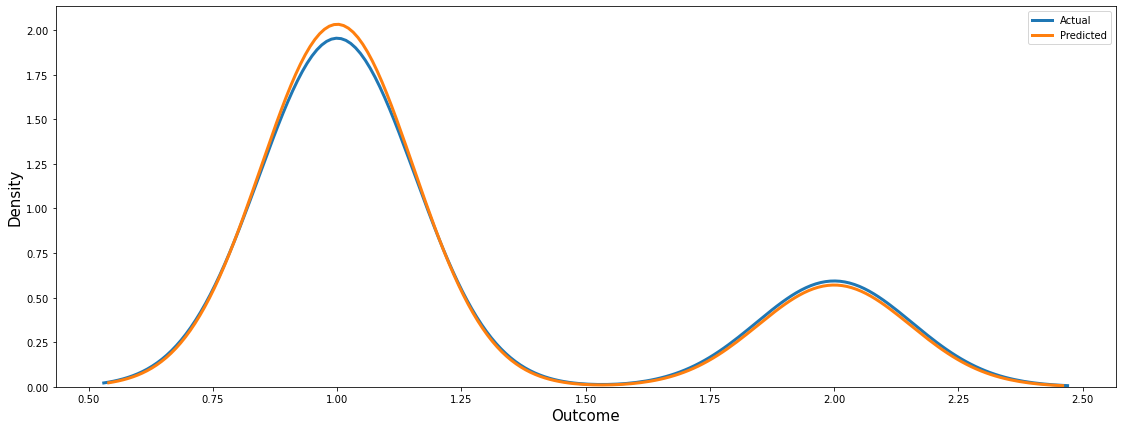

In [10]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = diabetes_df, x = y_test, label = "Actual", linewidth = 3)
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3)
plt.xlabel("Outcome", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

In [11]:
coef = pd.DataFrame({"Columns": X.columns,
                     "Coefficients": lr.coef_[0].round(2)})
coef

Columns  Coefficients
0               age         -0.36
1     tot_bilirubin         -0.37
2  direct_bilirubin         -0.78
3      tot_proteins         -0.28
4           albumin         -1.57
5          ag_ratio         -0.81
6              sgpt         -0.64
7              sgot          0.80
8           alkphos         -0.21

In [12]:
score = accuracy_score(y_test, y_pred)
print("Accuracy Score =", score)

Accuracy Score = 0.726027397260274


### Automatic Recursive Feature Elimination

In [13]:
# Create the RFE with a LogisticRegression estimator and 3 features to select
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=3, verbose=1)

# Fit the eliminator to the data
rfe.fit(X_train_std, y_train)

# Print the features and their ranking (high = dropped early on)
print(dict(zip(X.columns, rfe.ranking_)))

Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
{'age': 5, 'tot_bilirubin': 4, 'direct_bilirubin': 1, 'tot_proteins': 6, 'albumin': 1, 'ag_ratio': 1, 'sgpt': 3, 'sgot': 2, 'alkphos': 7}


In [14]:
# Print the features that are not eliminated
print(X.columns[rfe.support_])

Index(['direct_bilirubin', 'albumin', 'ag_ratio'], dtype='object')


In [15]:
y_pred = rfe.predict(X_test_std)
pd.DataFrame({"Actual": y_test, "Predicted": y_pred})[:10]

Actual  Predicted
288       1          1
157       1          1
139       1          1
263       1          1
20        1          1
116       1          1
155       1          1
7         1          1
487       1          1
554       1          1

In [16]:
# Calculates the test set accuracy
acc = accuracy_score(y_test, y_pred)
print("{0:.1%} accuracy on test set.".format(acc))

76.7% accuracy on test set.


### Building a random forest model

In [17]:
# Perform a 75% training and 25% test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Fit the random forest model to the training data
rf = RandomForestClassifier(random_state=0, n_estimators = 10)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
pd.DataFrame({"Actual": y_test, "Predicted": y_pred})[:10]

Actual  Predicted
246       1          1
92        1          1
386       2          1
186       1          1
389       1          1
103       2          1
506       1          1
14        1          2
52        1          1
496       1          2

In [18]:
# Print the importances per feature
print(dict(zip(X.columns, rf.feature_importances_.round(2))))

{'age': 0.14, 'tot_bilirubin': 0.08, 'direct_bilirubin': 0.07, 'tot_proteins': 0.16, 'albumin': 0.15, 'ag_ratio': 0.11, 'sgpt': 0.1, 'sgot': 0.1, 'alkphos': 0.08}


In [19]:
# Prints accuracy metrics and feature coefficients
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.6712328767123288


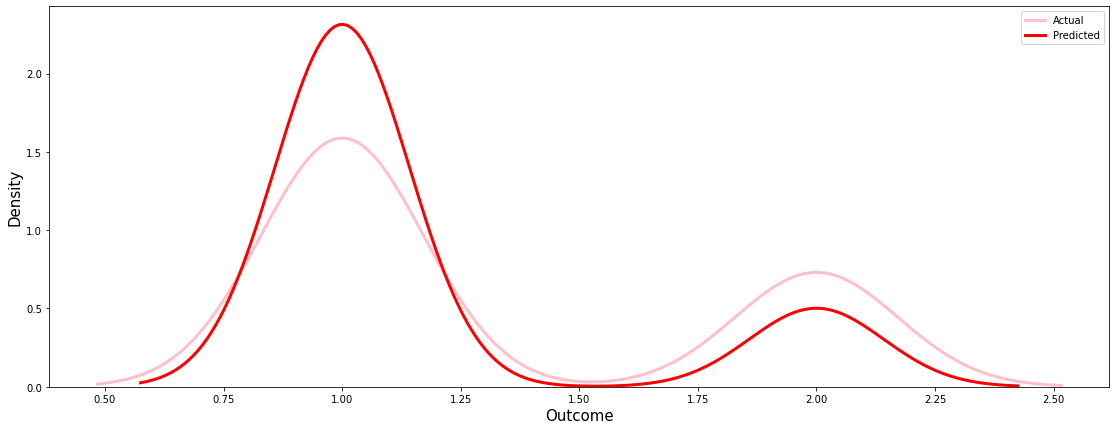

In [20]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = diabetes_df, x = y_test, label = "Actual", linewidth = 3, color = "pink")
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3, color = "red")
plt.xlabel("Outcome", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

### Random forest for feature selection

In [21]:
# Create a mask for features importances above the threshold
mask = rf.feature_importances_ > 0.11

# Apply the mask to the feature dataset X
reduced_X = X.loc[:, mask]

# prints out the selected column names
print(reduced_X.columns)

Index(['age', 'tot_proteins', 'albumin'], dtype='object')


### Recursive Feature Elimination with random forests

In [22]:
# Set the feature eliminator to remove 2 features on each step
rfe = RFE(estimator=RandomForestClassifier(n_estimators = 10), n_features_to_select=2, step = 2, verbose=1)

# Fit the model to the training data
rfe.fit(X_train, y_train)

# Create a mask
mask = rfe.support_

# Apply the mask to the feature dataset X and print the result
reduced_X = X.loc[:, mask]
print(reduced_X.columns)

Fitting estimator with 9 features.
Fitting estimator with 7 features.
Fitting estimator with 5 features.
Fitting estimator with 3 features.
Index(['tot_proteins', 'albumin'], dtype='object')


### Creating a LASSO regressor

In [23]:
female = pd.read_csv("Ansur_Female.csv")
male = pd.read_csv("Ansur_Male.csv") 
ansur_df = pd.concat([female, male])
ansur_df[:3]

Branch     Component  Gender  \
0          Combat Support  Regular Army  Female   
1  Combat Service Support  Regular Army  Female   
2  Combat Service Support  Regular Army  Female   

   abdominalextensiondepthsitting  acromialheight  acromionradialelength  \
0                             231            1282                    301   
1                             194            1379                    320   
2                             183            1369                    329   

   anklecircumference  axillaheight  balloffootcircumference  \
0                 204          1180                      222   
1                 207          1292                      225   
2                 233          1271                      237   

   balloffootlength  ...  waistdepth  waistfrontlengthsitting  \
0               177  ...         217                      345   
1               178  ...         168                      329   
2               196  ...         159                      367   

   waistheightomphalion  wristcircumference  wristheight  weight_kg  \
0                   942                 152          756       65.7   
1                  1032                 155          815       53.4   
2                  1035                 162          799       66.3   

   stature_m        BMI   BMI_class  Height_class  
0      1.560  26.997041  Overweight        Normal  
1      1.665  19.262506      Normal        Normal  
2      1.711  22.647148      Normal          Tall  

[3 rows x 99 columns]

In [24]:
ansur_df = ansur_df[ansur_df.columns.drop(["Branch", "Component", "Gender", "BMI_class", "Height_class"])]
ansur_df[:3]

abdominalextensiondepthsitting  acromialheight  acromionradialelength  \
0                             231            1282                    301   
1                             194            1379                    320   
2                             183            1369                    329   

   anklecircumference  axillaheight  balloffootcircumference  \
0                 204          1180                      222   
1                 207          1292                      225   
2                 233          1271                      237   

   balloffootlength  biacromialbreadth  bicepscircumferenceflexed  \
0               177                373                        315   
1               178                372                        272   
2               196                397                        300   

   bicristalbreadth  ...  waistbreadth  waistcircumference  waistdepth  \
0               263  ...           295                 850         217   
1               250  ...           254                 708         168   
2               276  ...           269                 727         159   

   waistfrontlengthsitting  waistheightomphalion  wristcircumference  \
0                      345                   942                 152   
1                      329                  1032                 155   
2                      367                  1035                 162   

   wristheight  weight_kg  stature_m        BMI  
0          756       65.7      1.560  26.997041  
1          815       53.4      1.665  19.262506  
2          799       66.3      1.711  22.647148  

[3 rows x 94 columns]

In [25]:
X = ansur_df[ansur_df.columns.drop("BMI")]

y = ansur_df["BMI"]

In [26]:
# Set the test size to 30% to get a 70-30% train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit the scaler on the training features and transform these in one go
X_train_std = scaler.fit_transform(X_train)

# Create the Lasso model
la = Lasso()

# Fit it to the standardized training data
la.fit(X_train_std, y_train)

Lasso()

**R-Squared**

In [27]:
# Transform the test set with the pre-fitted scaler
X_test_std = scaler.transform(X_test)

# Calculate the coefficient of determination (R squared) on X_test_std
r_squared = la.score(X_test_std, y_test)
print("The model can predict {0:.1%} of the variance in the test set.".format(r_squared))

The model can predict 83.9% of the variance in the test set.


**Zero Coefficient Features**

In [28]:
# Create a list that has True values when coefficients equal 0
zero_coef = la.coef_ == 0

# Calculate how many features have a zero coefficient
n_ignored = sum(zero_coef)
print("The model has ignored {} out of {} features.".format(n_ignored, len(la.coef_)))

The model has ignored 83 out of 93 features.


### Adjusting the regularization strength

In [29]:
# Find the highest alpha value with R-squared above 98%
la = Lasso(alpha=0.1, random_state=0)

# Fits the model and calculates performance stats
la.fit(X_train_std, y_train)
r_squared = la.score(X_test_std, y_test)
n_ignored_features = sum(la.coef_ == 0)

# Print peformance stats 
print("The model can predict {0:.1%} of the variance in the test set.".format(r_squared))
print("{} out of {} features were ignored.".format(n_ignored_features, len(la.coef_)))

The model can predict 98.6% of the variance in the test set.
72 out of 93 features were ignored.


### Creating a LassoCV regressor

In [30]:
X = ansur_df[ansur_df.columns.drop('bicepscircumferenceflexed')]

y = ansur_df["bicepscircumferenceflexed"]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [34]:
# Create and fit the LassoCV model on the training set
lcv = LassoCV(cv =3)
lcv.fit(scaler.fit_transform(X_train), y_train)
print('Optimal alpha = {0:.3f}'.format(lcv.alpha_))

Optimal alpha = 0.037


In [35]:
# Calculate R squared on the test set
r_squared = lcv.score(scaler.transform(X_test), y_test)
print('The model explains {0:.1%} of the test set variance'.format(r_squared))

The model explains 91.9% of the test set variance


In [36]:
# Create a mask for coefficients not equal to zero
lcv_mask = lcv.coef_ != 0
print('{} features out of {} selected'.format(sum(lcv_mask), len(lcv_mask)))

69 features out of 93 selected


### Ensemble models for extra votes

In [37]:
# Select 10 features with RFE on a GradientBoostingRegressor, drop 3 features on each step
rfe_gb = RFE(estimator=GradientBoostingRegressor(), 
             n_features_to_select=10, step=10, verbose=1)
rfe_gb.fit(X_train, y_train)

# Calculate the R squared on the test set
r_squared = rfe_gb.score(X_test, y_test)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

# Assign the support array to gb_mask
gb_mask = rfe_gb.get_support()

Fitting estimator with 93 features.
Fitting estimator with 83 features.
Fitting estimator with 73 features.
Fitting estimator with 63 features.
Fitting estimator with 53 features.
Fitting estimator with 43 features.
Fitting estimator with 33 features.
Fitting estimator with 23 features.
Fitting estimator with 13 features.
The model can explain 90.0% of the variance in the test set


In [42]:
# Apply the mask to the feature dataset X and print the result
reduced_X = X.loc[:, gb_mask]
print(reduced_X.columns)

Index(['bideltoidbreadth', 'chestcircumference', 'forearmcircumferenceflexed',
       'forearmforearmbreadth', 'shouldercircumference', 'shoulderelbowlength',
       'thighcircumference', 'waistdepth', 'weight_kg', 'BMI'],
      dtype='object')


In [41]:
# Select 10 features with RFE on a RandomForestRegressor, drop 3 features on each step
rfe_rf = RFE(estimator=RandomForestRegressor(n_estimators = 10), 
             n_features_to_select=10, step=10, verbose=1)
rfe_rf.fit(X_train, y_train)

# Calculate the R squared on the test set
r_squared = rfe_rf.score(X_test, y_test)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

# Assign the support array to gb_mask
rf_mask = rfe_rf.support_

Fitting estimator with 93 features.
Fitting estimator with 83 features.
Fitting estimator with 73 features.
Fitting estimator with 63 features.
Fitting estimator with 53 features.
Fitting estimator with 43 features.
Fitting estimator with 33 features.
Fitting estimator with 23 features.
Fitting estimator with 13 features.
The model can explain 88.7% of the variance in the test set


In [43]:
# Apply the mask to the feature dataset X and print the result
reduced_X = X.loc[:, rf_mask]
print(reduced_X.columns)

Index(['bideltoidbreadth', 'chestcircumference', 'elbowrestheight',
       'forearmcircumferenceflexed', 'forearmforearmbreadth',
       'shouldercircumference', 'thighcircumference', 'thighclearance',
       'weight_kg', 'BMI'],
      dtype='object')


### Combining 3 feature selectors

In [46]:
lm = LinearRegression()
# Sum the votes of the three models
votes = np.sum([lcv_mask, rf_mask, gb_mask], axis=0)

# Create a mask for features selected by all 3 models
meta_mask = votes >= 3

# Apply the dimensionality reduction on X
X_reduced = X.loc[:, meta_mask]

# Plug the reduced dataset into a linear regression pipeline
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=0)

lm.fit(scaler.fit_transform(X_train), y_train)

r_squared = lm.score(scaler.transform(X_test), y_test)

print('The model can explain {0:.1%} of the variance in the test set using {1:} features.'.format(r_squared, len(lm.coef_)))

The model can explain 90.0% of the variance in the test set using 6 features.
